使用ResNet50对MNIST数据集进行分类
===
![Images](images/04_08_001.png)

![Images](images/04_08_002.png)

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

# 2.导入数据集

In [3]:
train_dataset = datasets.MNIST(root='/input/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='/input/', 
                              train=False, 
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


# 3.模型

In [4]:
device = torch.device(DEVICE)
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [5]:
torch.manual_seed(RANDOM_SEED)

model = resnet34(NUM_CLASSES)
model.to(DEVICE)
 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

# 4.训练

In [6]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/0469 | Cost: 2.7476
Epoch: 001/020 | Batch 0050/0469 | Cost: 1.7531
Epoch: 001/020 | Batch 0100/0469 | Cost: 1.0555
Epoch: 001/020 | Batch 0150/0469 | Cost: 0.7628
Epoch: 001/020 | Batch 0200/0469 | Cost: 0.6652
Epoch: 001/020 | Batch 0250/0469 | Cost: 0.6022
Epoch: 001/020 | Batch 0300/0469 | Cost: 0.5114
Epoch: 001/020 | Batch 0350/0469 | Cost: 0.4114
Epoch: 001/020 | Batch 0400/0469 | Cost: 0.3579
Epoch: 001/020 | Batch 0450/0469 | Cost: 0.3847
Epoch: 001/020 | Train: 91.287%
Time elapsed: 0.76 min
Epoch: 002/020 | Batch 0000/0469 | Cost: 0.4184
Epoch: 002/020 | Batch 0050/0469 | Cost: 0.2322
Epoch: 002/020 | Batch 0100/0469 | Cost: 0.2970
Epoch: 002/020 | Batch 0150/0469 | Cost: 0.2805
Epoch: 002/020 | Batch 0200/0469 | Cost: 0.3483
Epoch: 002/020 | Batch 0250/0469 | Cost: 0.2879
Epoch: 002/020 | Batch 0300/0469 | Cost: 0.1677
Epoch: 002/020 | Batch 0350/0469 | Cost: 0.1563
Epoch: 002/020 | Batch 0400/0469 | Cost: 0.3314
Epoch: 002/020 | Batch 0450/0469 

Epoch: 016/020 | Batch 0200/0469 | Cost: 0.0031
Epoch: 016/020 | Batch 0250/0469 | Cost: 0.0869
Epoch: 016/020 | Batch 0300/0469 | Cost: 0.0176
Epoch: 016/020 | Batch 0350/0469 | Cost: 0.0050
Epoch: 016/020 | Batch 0400/0469 | Cost: 0.0025
Epoch: 016/020 | Batch 0450/0469 | Cost: 0.0082
Epoch: 016/020 | Train: 99.765%
Time elapsed: 11.96 min
Epoch: 017/020 | Batch 0000/0469 | Cost: 0.0128
Epoch: 017/020 | Batch 0050/0469 | Cost: 0.0690
Epoch: 017/020 | Batch 0100/0469 | Cost: 0.0315
Epoch: 017/020 | Batch 0150/0469 | Cost: 0.0156
Epoch: 017/020 | Batch 0200/0469 | Cost: 0.0046
Epoch: 017/020 | Batch 0250/0469 | Cost: 0.0340
Epoch: 017/020 | Batch 0300/0469 | Cost: 0.0026
Epoch: 017/020 | Batch 0350/0469 | Cost: 0.0183
Epoch: 017/020 | Batch 0400/0469 | Cost: 0.0069
Epoch: 017/020 | Batch 0450/0469 | Cost: 0.0061
Epoch: 017/020 | Train: 99.700%
Time elapsed: 12.68 min
Epoch: 018/020 | Batch 0000/0469 | Cost: 0.0050
Epoch: 018/020 | Batch 0050/0469 | Cost: 0.0022
Epoch: 018/020 | Batch 0

# 5.评估

In [7]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 98.46%


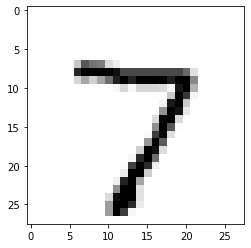

In [8]:
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features
    targets = targets
    break
    
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [9]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%
